# Tensorflow로 모델링하는 2가지 방법
- Sequential 모델을 활용하는 방법
  - Keras에서 제공하는 레이어들을 이어붙여가면서 모델링하는 방법
  - 쉽고 빠르게 모델링 가능
  - 커스터마이징이 조금 힘들다
  
- Functional API 활용하는 방법
  - 개발자가 직접 레이어를 정의해서 keras의 레이어처럼 사용하게 할 수 있다.(tf.keras.layers 상속)
  - 각종 Loss, Optimizer 등을 직접 만들어서 사용할 수 있다.

# tf.data 사용하기
- 일반적인 배열이 아닌, 병렬 처리된 배열을 이용하여 매우 빠른 속도로 데이터의 입출력이 가능
- dataset 이라는 개념을 이용해 feature, label을 손쉽게 관리 가능

In [85]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

In [86]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

X_train, X_test = X_train / 255.0, X_test / 255.0

## tf.data의 함수들
  - from_tensor_slices()
    - feature, label을 합친 데이터세트(ds)를 생성
  - shuffle()
    - 랜덤하게 섞기
  - batch()
    - 배치 만들기

In [87]:
# 제너레이트할 데이터를 넣어준다. 데이터를 병렬로 처리할 수 있다. (속도가 매우 빨라진다.)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# 데이터 섞기. 매개변수 숫자 : 랜덤 시드X, 버퍼사이즈O. (보통 1kb 정도로 설정.)
# 1kb 씩 뽑아서 섞고,,, 병렬적 처리
train_ds = train_ds.shuffle(1000)

# 배치 만들기
train_ds = train_ds.batch(32)  # iteration(반복) 할때마다 batch_size만큼 데이터가 나온다.

In [88]:
# 테스트 ds 만들기
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# 테스트 세트는 셔플이 필요 없다.
test_ds = test_ds.batch(32)

# 훈련할 때는 셔플이 필요하지만 테스트할 때는 필요없다.
# 단, 훈련할 때와 배치의 크기는 동일해야 한다.

## tf.data로 만든 데이터의 시각화

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

take() 함수를 이용하면 데이터를 배치 사이즈만큼 가지고 올 수 있다.(보통 반복문에서 사용)
- 매개변수에 2 -> 2개씩 가져오겠다.
- 아무것도 쓰지 않는다 -> 전부 다 가져오겠다.

In [90]:
# take는 2개의 결과를 리턴 (feature_batch, label_batch)
for images, labels in train_ds.take(2):
  print(images.shape)

(32, 28, 28, 1)
(32, 28, 28, 1)


In [91]:
# 랜덤하게 배치를 만들어서 뽑아주는 것이기 때문에 그때 그때 다를 수 있다.

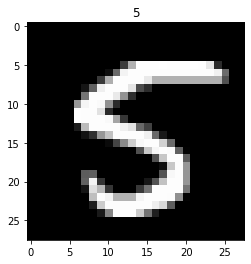

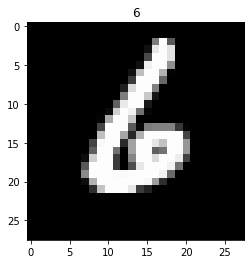

In [92]:
# 첫번째 배치의 첫번째 이미지
# 두번째 배치의 두번째 이미지
for images, labels in train_ds.take(2):
  image = images[0, ..., 0]
  plt.imshow(image, "gray")
  label = labels.numpy()[0]
  plt.title(label)
  plt.show()

# Conv2D 모델링 하기

In [93]:
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import Dropout, Flatten, Dense

In [94]:
input_shape = (28, 28, 1)
num_classes = 10

inputs = layers.Input(shape=input_shape)

# Feature Extraction
net = Conv2D(32, 3, padding="SAME")(inputs)
net = Activation("relu")(net)
net = Conv2D(32, 3, padding="SAME")(net)
net = Activation("relu")(net)
net = MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

net = Conv2D(64, 3, padding="SAME")(net)
net = Activation("relu")(net)
net = Conv2D(64, 3, padding="SAME")(net)
net = Activation("relu")(net)
net = MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

# Fully Connected
net = Flatten()(net)
net = Dense(512)(net)
net = Activation("relu")(net)
net = Dropout(0.25)(net)

# Output Layer
net = Dense(num_classes)(net)
net = Activation("softmax")(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name="Basic_CNN")

In [95]:
# 지난번의 컴파일 과정
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [96]:
# tf.data의 훈련 과정
model.fit(train_ds, epochs=1)  # ds에는 feature, label, batch 정보가 모두 들어있다.
# train_ds만 주면 훈련 가능
# label을 따로 넣어줄 필요가 없다.

1875/1875 [==============================] - 7s 4ms/step - loss: 0.1257


# Functional API 사용해보기
Loss Function이나 Optimizer등을 Tensorflow 및 Keras에서 제공하는 것이 아닌 사용자가 직접 함수를 만들어서 사용할 때 커스터마이징하기 위한 방법

In [97]:
# Loss Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Optimizer
optimizer = tf.keras.optimizers.Adam()

In [98]:
# 컴파일, 훈련과정에 커스터마이징 가능

In [99]:
# 평가 방법도 커스터마이징 기능
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

# @tf.function이란?

In [100]:
@tf.function
def train_step(images, labels):
  # 자동 미분을 위한 정보 뽑아내기(오차 역전파)
  with tf.GradientTape() as tape:
    prediction = model(images)  # model 안쪽에 데이터만 집어넣게 되면, 모델이 train 모드가 된다.
    loss = loss_object(labels, prediction)
  
  # 오차역전파 수행하기
  gradients = tape.gradient(loss, model.trainable_variables)
  # tape : 자동미분객체
  # loss, update할 매개변수(가중치, 편향) 목록들 필요
  # loss를 가지고 가중치, 편향의 기울기를 구하겠다 -> 역전파를 수행하는 부분
  
  # gradients 에 각 매개변수들의 기울기가 들어가있음
  
  # 이제 기울기 update 필요
  # update해주는 건 optimizer가 그 역할을 해줌
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # 이 때의 loss 기록 필요
  # train_loss, train_accuracy
  # update 되기 전의 loss, 훈련 시의 loss 값 기록
  
  # loss, accuracy 기록하기  # 평가 기준 기록하기
  # 그래야지 배치에 대해 얼마만큼 떨어져있는 지를 알 수 있음
  train_loss(loss)
  train_accuracy(labels, prediction)

In [101]:
@tf.function
def test_step(images, labels):
  prediction = model(images)
  t_loss = loss_object(labels, prediction)

  test_loss(t_loss)
  test_accuracy(labels, prediction)

In [102]:
# 여기서 model에 다시 fit 하게 되면
# 추가 학습이 일어나게 된 거임

# 그러므로 모델 다시 만들어야 함

In [103]:
# MNIST 추가 학습을 방지가힉 위한 리모델링

input_shape = (28, 28, 1)
num_classes = 10

inputs = layers.Input(shape=input_shape)

# Feature Extraction
net = Conv2D(32, 3, padding="SAME")(inputs)
net = Activation("relu")(net)
net = Conv2D(32, 3, padding="SAME")(net)
net = Activation("relu")(net)
net = MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

net = Conv2D(64, 3, padding="SAME")(net)
net = Activation("relu")(net)
net = Conv2D(64, 3, padding="SAME")(net)
net = Activation("relu")(net)
net = MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

# Fully Connected
net = Flatten()(net)
net = Dense(512)(net)
net = Activation("relu")(net)
net = Dropout(0.25)(net)

# Output Layer
net = Dense(num_classes)(net)
net = Activation("softmax")(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name="Basic_CNN")

In [104]:
# 모델 초기화해준 것

In [105]:
# Functional API 방식으로 훈련 시키기

epochs = 2
for epoch in range(epochs):
  
  # 한 에폭에서 모든 데이터에 대한 학습을 마친다.
  for images, labels in train_ds:
    train_step(images, labels)  # 이게 1epoch에 대한 학습

  # 테스트 수행
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)
  
  template = 'Epoch {}, Loss : {:.3f}, Accuracy: {:.3f}, Test Loss : {:.3f}, Test Accuracy: {:.3f}'
  print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100))

Epoch 1, Loss : 0.100, Accuracy: 96.965, Test Loss : 0.057, Test Accuracy: 98.220
Epoch 2, Loss : 0.067, Accuracy: 97.946, Test Loss : 0.047, Test Accuracy: 98.525
